In [1]:
import pandas as pd
# pd.set_option("display.float_format", "{:.3f}".format)
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.utils import Bunch
from sklearn.metrics import (
    balanced_accuracy_score,
    roc_auc_score,
    accuracy_score,
    recall_score,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    RocCurveDisplay)
from sklearn.metrics import classification_report
from sklearn.utils import class_weight
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
import shap
import seaborn as sns
from IPython.display import display, Markdown, Latex

In [2]:
from fairlearn.metrics import (
    MetricFrame,
    true_positive_rate,
    false_positive_rate,
    false_negative_rate,
    selection_rate,
    count,
    false_negative_rate_difference
)

from fairlearn.postprocessing import ThresholdOptimizer, plot_threshold_optimizer
from fairlearn.postprocessing._interpolated_thresholder import InterpolatedThresholder
from fairlearn.postprocessing._threshold_operation import ThresholdOperation
from fairlearn.reductions import ExponentiatedGradient, EqualizedOdds, TruePositiveRateParity

In [3]:
dff = pd.read_csv('/Users/kayadetunji/Documents/AWI_GEN_PROJECT/cvd_data_awigenv1.csv').drop(columns = 
       ['Unnamed: 0', 'study_id', 'chf_meds_qc','angina_meds_qc', 'pain_action_stop_or_slow_qc', 'pain_action_rest_qc',
       'pain_action_medicine_qc', 'pain_action_carry_on_qc',
       'relief_standstill_qc', 'relief_standstill_qc.1', 'pain_location_1_qc',
       'pain_location_2_qc', 'pain_location_3_qc', 'pain_location_4_qc',
       'pain_location_5_qc', 'pain_location_6_qc', 'pain_location_7_qc',
       'pain_location_8_qc', 'pain_location_9_qc', 'pain_location_10_qc',
       'pain_location_11_qc', 'pain_location_12_qc', 'pain_location_13_qc',
       'pain_location_14_qc', 'pain_location_15_qc', 'pain_location_16_qc',
       'pain_location_17_qc', 'pain_location_18_qc','angina_treat_now_qc', 'angina_traditional_qc', 'pain_qc', 'pain2_qc'])

In [4]:
predictor_cols = ['site', 'age', 'sex', 'number_of_children_c', 
        'partnership_status_c_qc', 'highest_level_of_education_qc', 'occupation_qc',
       'ses_site_quintile_c_qc', 'smoking_status_c_qc', 'alcohol_use_status_c_qc', 
#        'days_fruit_qc', 'days_veg_qc', 'days_bread_qc', 'sugardrinks_qc', 
       'avg_sleep_per_night_c', 'mvpa_c',
#        'asthma_qc', 
       'obesity_mom_qc','hiv_final_status_c', 'pesticide_qc',
       'waist_circumference_qc', 'hip_circumference_qc', 
       'waist_hip_r_c_qc','bp_sys_average_qc', 'pulse_average_qc',
       'visceral_fat_qc', 'subcutaneous_fat_qc', 'mean_cimt_right_qc',
       'mean_cimt_left_qc', 'ldl_qc', 'triglycerides_qc',
       'acr_qc','bmi_c_qc', 'cholesterol_1_qc']
outcome_cols = ['CVD']

Calculate the CVD variables and CVD-MM outcome variables and store in a new column

In [5]:
# Simple Function to calcuate CVD
def calculate_CVD(a,b,c,d,e):
    col=0
    if (int(a)==1 or int(b)==1 or int(c)==1 or int(d)==1 or int(e)==1):
        col=1
    elif (int(a)==0 and int(b)==0 and int(c)==0 and int(d)==0 and int(e)==0):
        col = 0
    elif (int(a)==pd.isna and int(b)==pd.isna and int(c)==pd.isna and int(d)==pd.isna and int(e)==pd.isna):
        col = 0
    return col

In [6]:
com=[]
for i in range(dff.shape[0]):
    com.append(calculate_CVD(dff.stroke_qc.iloc[i], dff.transient_ischemic_attack_qc.iloc[i], dff.heartattack_qc.iloc[i], dff.congestive_heart_failure_qc.iloc[i], dff.angina_qc.iloc[i]))
y1=pd.DataFrame(com, columns=['CVD'])

Rework the imputed values of missing data and outliers back to missing DATA.

In [7]:
dff1 = dff.replace([-999, -222, -111], np.nan).copy()

Treat the missing values using the Bayesian imputation

[IterativeImputer] Early stopping criterion not reached.


<Axes: ylabel='Density'>

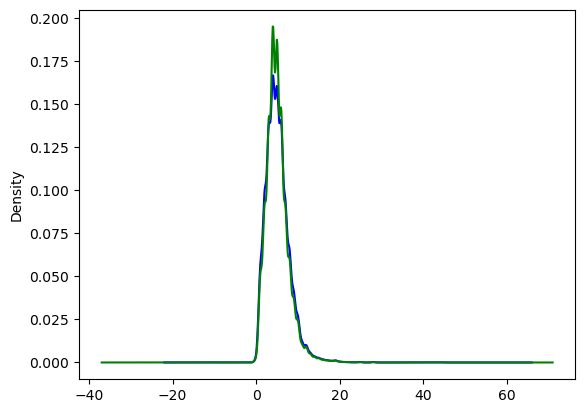

In [8]:
from sklearn.linear_model import BayesianRidge
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
imputer_bayes = IterativeImputer(
    estimator=BayesianRidge(),
    max_iter=10,
    random_state=0)

# let's create a MICE imputer using Bayes as estimator

imputer = IterativeImputer(
    estimator=BayesianRidge(), # the estimator to predict the NA
    initial_strategy='mean', # how will NA be imputed in step 1
    max_iter=10, # number of cycles
    imputation_order='ascending', # the order in which to impute the variables
    n_nearest_features=None, # whether to limit the number of predictors
    skip_complete=True, # whether to ignore variables without NA
    random_state=0,
)
imputer.fit(dff1[predictor_cols])
train_t = imputer.transform(dff1[predictor_cols])
# train_x = imputer.transform(data.iloc[:,2:])
treated = pd.DataFrame(train_t, columns=dff1[predictor_cols].columns)
treated = treated.apply(np.ceil)

fig = plt.figure()
ax = fig.add_subplot(111)
dff1['number_of_children_c'].plot(kind='kde', ax=ax, color='blue')
treated['number_of_children_c'].plot(kind='kde', ax=ax, color='green')

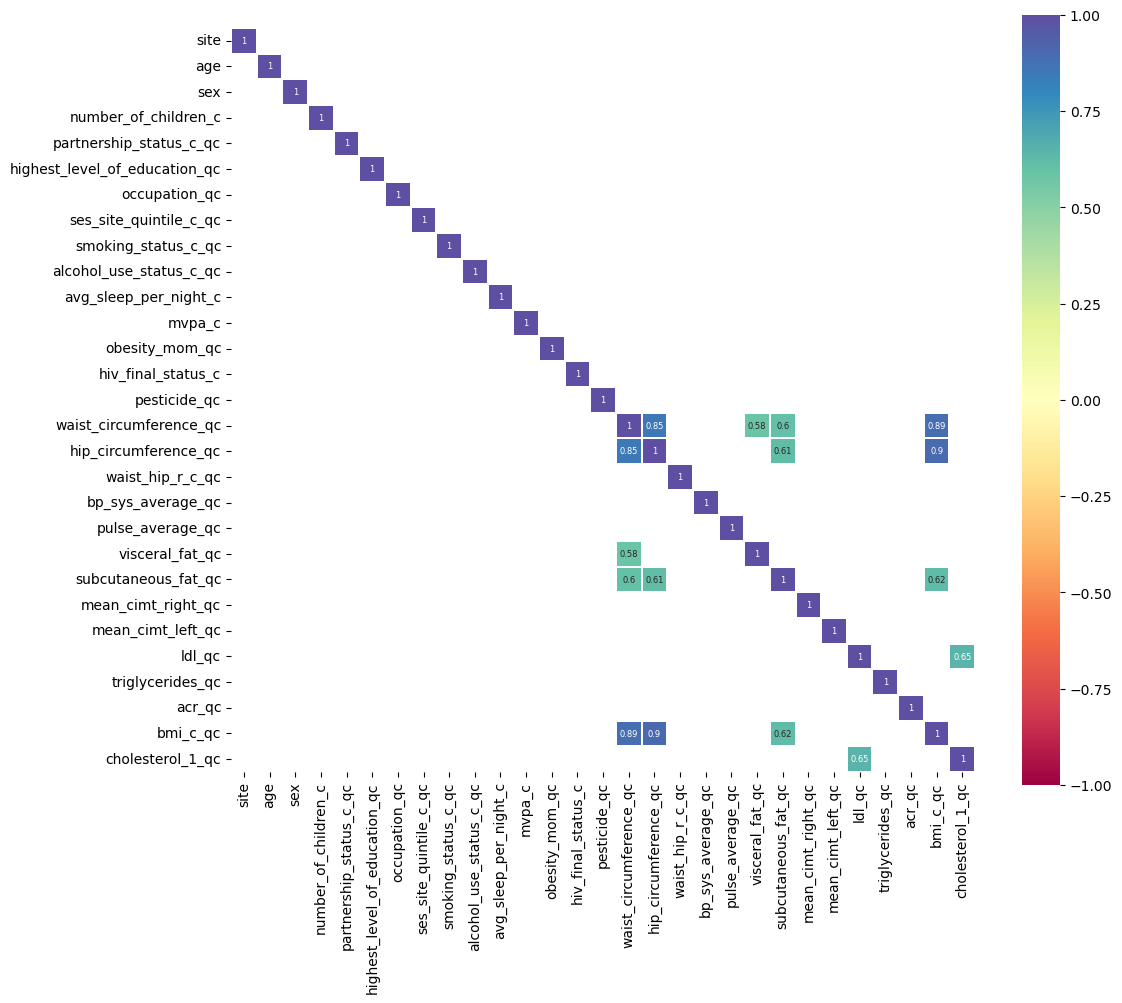

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

# Identify correlated variables using correlation coefficients
correlation_matrix = treated[predictor_cols].corr().abs()
upper_triangle = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))
highly_correlated = [column for column in upper_triangle.columns if any(upper_triangle[column] > 0.8)]


plt.figure(figsize=(12,10))
sns.heatmap(correlation_matrix[(correlation_matrix >= 0.5) | (correlation_matrix <= -0.4)], 
            cmap='Spectral', vmax=1.0, vmin=-1.0, linewidths=0.1,
            annot=True, annot_kws={"size": 6}, square=True);

In [10]:
# Remove highly correlated variables
# predictor_cols = ['bmi_c_qc', 'age', 'cimt_mean_max', 'cholesterol_1_qc',
#        'friedewald_ldl_c_c_qc', 'hdl_qc', 'triglycerides_qc',
#        'waist_hip_r_c_qc', 'waist_circumference_qc', 'visceral_fat_qc',
#        'subcutaneous_fat_qc', 'sex', 'hiv_final_status_c',
#        'highest_level_of_education_qc', 'partnership_status_c_qc',
#        'ses_site_quintile_c_qc', 'occupation_qc', 'mvpa_cat_c',
#        'alcohol_use_status_c_qc', 'smoking_status_c_qc']
predictors = [predictor for predictor in predictor_cols if predictor not in highly_correlated]

# Calculate VIF to check for multicollinearity
# X = data[predictors]
# vif = pd.DataFrame()
# vif['Feature'] = X.columns
# vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# # Remove variables with high VIF (> 10)
# predictors = [predictor for predictor in predictors if predictor not in vif[vif['VIF'] > 10]['Feature']]
print(predictor_cols)
print(predictors)

['site', 'age', 'sex', 'number_of_children_c', 'partnership_status_c_qc', 'highest_level_of_education_qc', 'occupation_qc', 'ses_site_quintile_c_qc', 'smoking_status_c_qc', 'alcohol_use_status_c_qc', 'avg_sleep_per_night_c', 'mvpa_c', 'obesity_mom_qc', 'hiv_final_status_c', 'pesticide_qc', 'waist_circumference_qc', 'hip_circumference_qc', 'waist_hip_r_c_qc', 'bp_sys_average_qc', 'pulse_average_qc', 'visceral_fat_qc', 'subcutaneous_fat_qc', 'mean_cimt_right_qc', 'mean_cimt_left_qc', 'ldl_qc', 'triglycerides_qc', 'acr_qc', 'bmi_c_qc', 'cholesterol_1_qc']
['site', 'age', 'sex', 'number_of_children_c', 'partnership_status_c_qc', 'highest_level_of_education_qc', 'occupation_qc', 'ses_site_quintile_c_qc', 'smoking_status_c_qc', 'alcohol_use_status_c_qc', 'avg_sleep_per_night_c', 'mvpa_c', 'obesity_mom_qc', 'hiv_final_status_c', 'pesticide_qc', 'waist_circumference_qc', 'waist_hip_r_c_qc', 'bp_sys_average_qc', 'pulse_average_qc', 'visceral_fat_qc', 'subcutaneous_fat_qc', 'mean_cimt_right_qc',

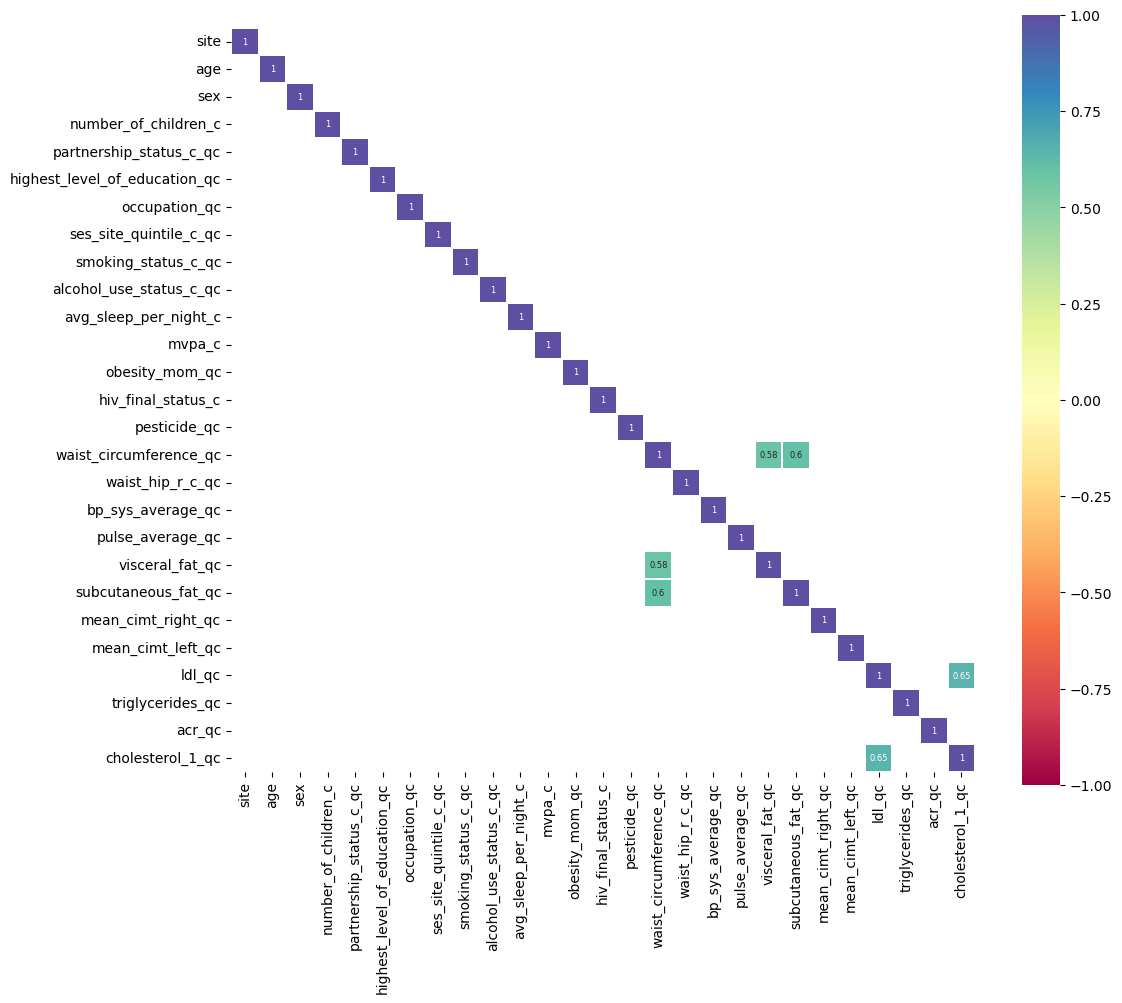

In [11]:
# Identify correlated variables using correlation coefficients
correlation_matrix = treated[predictors].corr().abs()
upper_triangle = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))
highly_correlated = [column for column in upper_triangle.columns if any(upper_triangle[column] > 0.8)]


plt.figure(figsize=(12,10))
sns.heatmap(correlation_matrix[(correlation_matrix >= 0.5) | (correlation_matrix <= -0.4)], 
            cmap='Spectral', vmax=1.0, vmin=-1.0, linewidths=0.1,
            annot=True, annot_kws={"size": 6}, square=True);

#### Understanding the imbalance of the data

In [12]:
y1['CVD'].value_counts(normalize=True)

0    0.963182
1    0.036818
Name: CVD, dtype: float64

<Axes: >

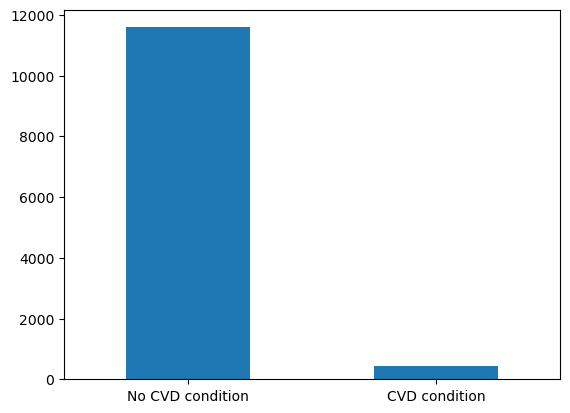

In [13]:
CVD_MM = ["No CVD condition" if y1['CVD'].iloc[i] == 0 else "CVD condition" for i in range(y1['CVD'].shape[0])]
CVD_MM = pd.DataFrame(CVD_MM, columns=['CVD'])
CVD_MM['CVD'].value_counts().plot(kind='bar', rot=0)

<Axes: >

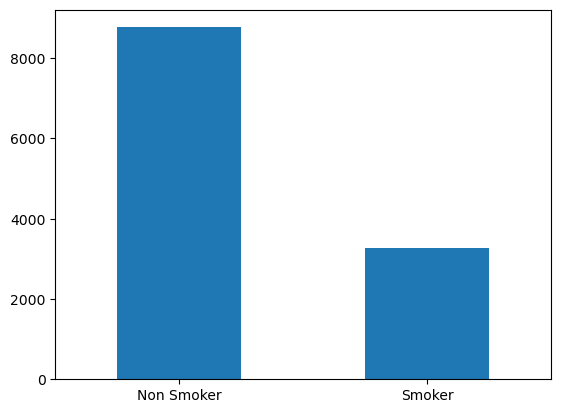

In [14]:
Smoke = ["Non Smoker" if dff1['smoking_status_c_qc'].iloc[i] == 0 else "Smoker" for i in range(y1['CVD'].shape[0])]
Smoke = pd.DataFrame(Smoke, columns=['Smoke'])
Smoke['Smoke'].value_counts().plot(kind='bar', rot=0)

<Axes: >

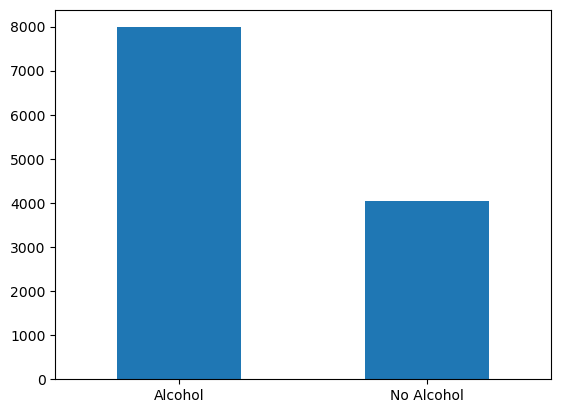

In [39]:
Alco = ["No Alcohol" if dff1['alcohol_use_status_c_qc'].iloc[i] == 0 else "Alcohol" for i in range(y1['CVD'].shape[0])]
Alco = pd.DataFrame(Alco, columns=['Alco'])
Alco['Alco'].value_counts().plot(kind='bar', rot=0)

Check the cases of CVD according to sites

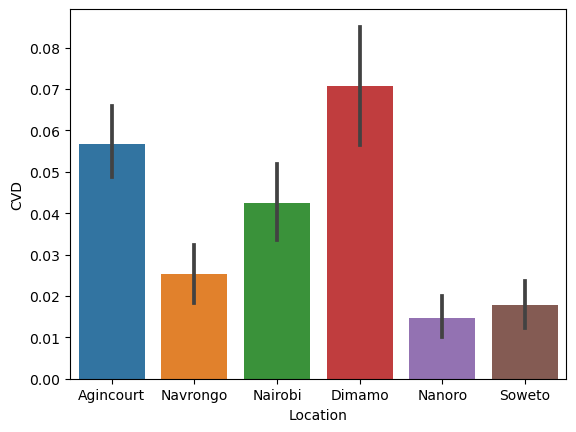

In [15]:
map_dict = {1: "Agincourt", 2: "Dimamo", 3: "Nairobi", 4: "Nanoro", 5: "Navrongo", 6: "Soweto"}
dff1["Location"] = dff1["site"].map(map_dict)
check = pd.concat([y1,dff1.loc[:,'Location']],axis=1)
sns.barplot(x="Location", y="CVD", data=check, errorbar=('ci', 95));

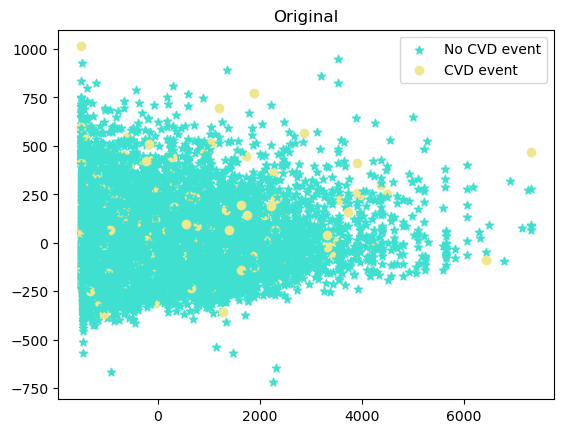

In [16]:
from sklearn.decomposition import PCA
import pylab as pl
pca = PCA(n_components=2).fit(treated[predictor_cols])
pca_2d = pca.transform(treated[predictor_cols])
y_rs = y1['CVD']
pca_2d 
for i in range(0, dff1.shape[0]):
    if y_rs[i] == 0:
      c1 = pl.scatter(pca_2d[i,0],pca_2d[i,1],c='turquoise', marker='*')
    elif y_rs[i] == 1:
      c2 = pl.scatter(pca_2d[i,0],pca_2d[i,1],c='khaki', marker='o')  
pl.legend([c1, c2], ['No CVD event', 'CVD event'])
pl.title('Original')
# pl.axis([-4, 5, -4, 4])  # x axis (-4,5), y axis (-4,4)
pl.show()

In [ ]:
print('Random undersampling {}'.format(Counter(y_rs)))

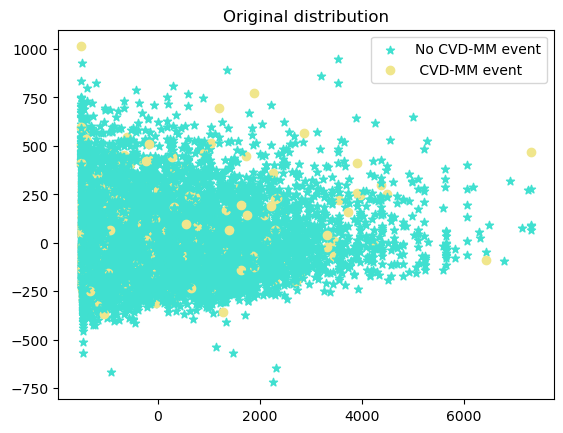

In [17]:
from sklearn.decomposition import PCA
import pylab as pl
pca = PCA(n_components=2).fit(treated[predictor_cols])
pca_2d = pca.transform(treated[predictor_cols])
y_rs = y1['CVD']
pca_2d 
for i in range(0, dff1.shape[0]):
    if y_rs[i] == 1:
      c1 = pl.scatter(pca_2d[i,0],pca_2d[i,1],c='khaki', marker='o')
    elif y_rs[i] == 0:
      c2 = pl.scatter(pca_2d[i,0],pca_2d[i,1],c='turquoise', marker='*')  
pl.legend([c2, c1], ['No CVD-MM event', ' CVD-MM event'])
pl.title('Original distribution')
# pl.axis([-4, 5, -4, 4])  # x axis (-4,5), y axis (-4,4)
pl.show()

In [67]:
print('Training dataset shape {}'.format(Counter(y1['CVD'])))

Training dataset shape Counter({0: 11589, 1: 443})


Random undersampling Counter({0: 1000, 1: 443})


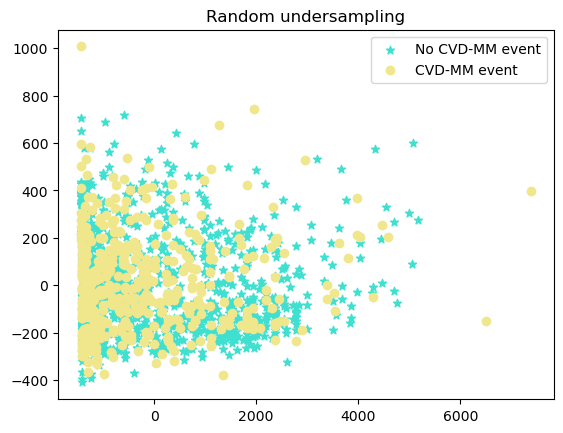

In [19]:
from imblearn.datasets import make_imbalance
from collections import Counter
X_rs, y_rs = make_imbalance(treated[predictor_cols], y1['CVD'], sampling_strategy={1: 443, 0: 1000},
                      random_state=0)
print('Random undersampling {}'.format(Counter(y_rs)))
pca = PCA(n_components=2).fit(X_rs)
pca_2d = pca.transform(X_rs)
# y_rs = y1['CVD']
pca_2d 
for i in range(0, pca_2d.shape[0]):
    if y_rs[i] == 1:
      c1 = pl.scatter(pca_2d[i,0],pca_2d[i,1],c='khaki', marker='o')
    elif y_rs[i] == 0:
      c2 = pl.scatter(pca_2d[i,0],pca_2d[i,1],c='turquoise', marker='*')  
pl.legend([c2, c1], ['No CVD-MM event', 'CVD-MM event'])
pl.title('Random undersampling')
# pl.axis([-4, 5, -4, 4])  # x axis (-4,5), y axis (-4,4)
pl.show()

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning


Cluster centriods undersampling Counter({0: 1000, 1: 443})


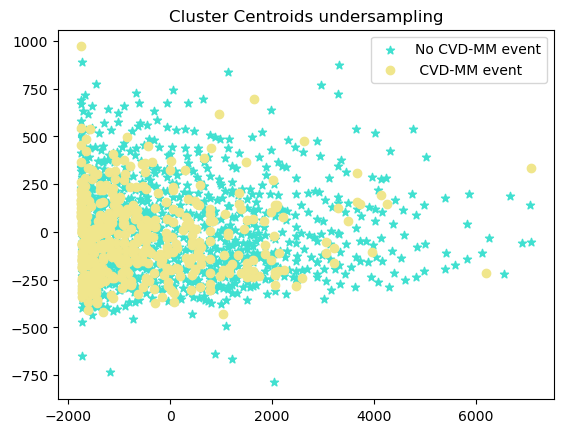

In [20]:
from imblearn.under_sampling import ClusterCentroids 
sampler = ClusterCentroids(sampling_strategy={1: 443, 0: 1000})
X_rs, y_rs = sampler.fit_resample(treated[predictor_cols], y1['CVD'])
print('Cluster centriods undersampling {}'.format(Counter(y_rs)))
pca = PCA(n_components=2).fit(X_rs)
pca_2d = pca.transform(X_rs)
# y_rs = y1['CVD']
pca_2d 
for i in range(0, pca_2d.shape[0]):
    if y_rs[i] == 1:
      c1 = pl.scatter(pca_2d[i,0],pca_2d[i,1],c='khaki', marker='o')
    elif y_rs[i] == 0:
      c2 = pl.scatter(pca_2d[i,0],pca_2d[i,1],c='turquoise', marker='*')  
pl.legend([c2, c1], ['No CVD-MM event', ' CVD-MM event'])
pl.title('Cluster Centroids undersampling')
# pl.axis([-4, 5, -4, 4])  # x axis (-4,5), y axis (-4,4)
pl.show()

NearestNeighbours Clearning Rule undersampling Counter({0: 10373, 1: 443})


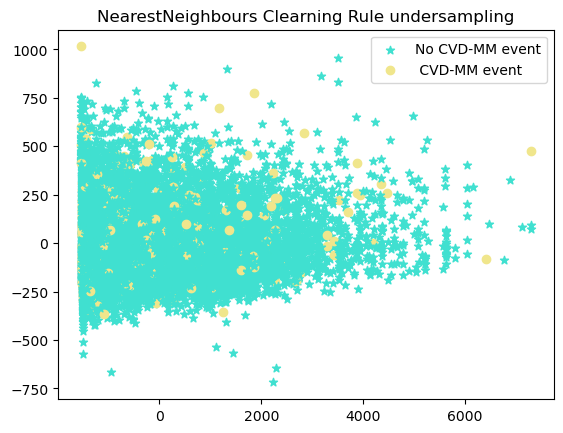

In [21]:
from imblearn.under_sampling import NeighbourhoodCleaningRule 
sampler = NeighbourhoodCleaningRule() 
X_rs, y_rs = sampler.fit_resample(treated[predictor_cols], y1['CVD'])
print('NearestNeighbours Clearning Rule undersampling {}'.format(Counter(y_rs)))
pca = PCA(n_components=2).fit(X_rs)
pca_2d = pca.transform(X_rs)
# y_rs = y1['CVD']
pca_2d 
for i in range(0, pca_2d.shape[0]):
    if y_rs[i] == 1:
      c1 = pl.scatter(pca_2d[i,0],pca_2d[i,1],c='khaki', marker='o')
    elif y_rs[i] == 0:
      c2 = pl.scatter(pca_2d[i,0],pca_2d[i,1],c='turquoise', marker='*')  
pl.legend([c2, c1], ['No CVD-MM event', ' CVD-MM event'])
pl.title('NearestNeighbours Clearning Rule undersampling')
# pl.axis([-4, 5, -4, 4])  # x axis (-4,5), y axis (-4,4)
pl.show()

NearestNeighbours Clearning Rule undersampling Counter({0: 1864, 1: 443})


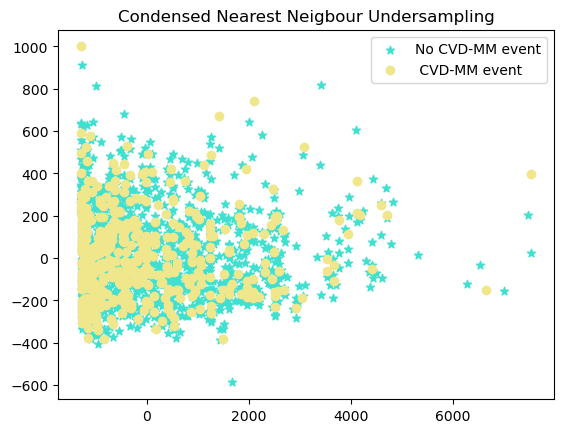

In [22]:
from imblearn.under_sampling import CondensedNearestNeighbour
sampler = CondensedNearestNeighbour() 
X_rs, y_rs = sampler.fit_resample(treated[predictor_cols], y1['CVD'])
print('NearestNeighbours Clearning Rule undersampling {}'.format(Counter(y_rs)))
pca = PCA(n_components=2).fit(X_rs)
pca_2d = pca.transform(X_rs)
# y_rs = y1['CVD']
pca_2d 
for i in range(0, pca_2d.shape[0]):
    if y_rs[i] == 1:
      c1 = pl.scatter(pca_2d[i,0],pca_2d[i,1],c='khaki', marker='o')
    elif y_rs[i] == 0:
      c2 = pl.scatter(pca_2d[i,0],pca_2d[i,1],c='turquoise', marker='*')  
pl.legend([c2, c1], ['No CVD-MM event', ' CVD-MM event'])
pl.title('Condensed Nearest Neigbour Undersampling')
# pl.axis([-4, 5, -4, 4])  # x axis (-4,5), y axis (-4,4)
pl.show()

In [102]:
sampler = CondensedNearestNeighbour() 
data_bal_CNN_X, data_bal_CNN_Y = sampler.fit_resample(treated[predictor_cols], y1['CVD'])
print('NearestNeighbours Clearning Rule undersampling {}'.format(Counter(y_rs)))
# pca = PCA(n_components=2).fit(X_rs)
# pca_2d = pca.transform(X_rs)

NearestNeighbours Clearning Rule undersampling Counter({0: 1864, 1: 443})


In [133]:
data_balance = []
for i in range(X_rs.shape[0]):
    if treated.index[i] == X_rs.index[i]:
        data_balance.append(treated.iloc[i,:].values)

Near miss undersampling Counter({0: 443, 1: 443})


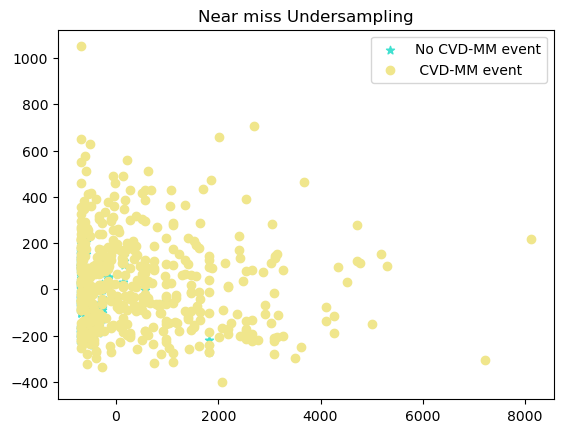

In [23]:
from imblearn.under_sampling import NearMiss
sampler = NearMiss() 
X_rs, y_rs = sampler.fit_resample(treated[predictor_cols], y1['CVD'])
print('Near miss undersampling {}'.format(Counter(y_rs)))
pca = PCA(n_components=2).fit(X_rs)
pca_2d = pca.transform(X_rs)
# y_rs = y1['CVD']
pca_2d 
for i in range(0, pca_2d.shape[0]):
    if y_rs[i] == 1:
      c1 = pl.scatter(pca_2d[i,0],pca_2d[i,1],c='khaki', marker='o')
    elif y_rs[i] == 0:
      c2 = pl.scatter(pca_2d[i,0],pca_2d[i,1],c='turquoise', marker='*')  
pl.legend([c2, c1], ['No CVD-MM event', ' CVD-MM event'])
pl.title('Near miss Undersampling')
# pl.axis([-4, 5, -4, 4])  # x axis (-4,5), y axis (-4,4)
pl.show()

### Resample the data (Undersampling given the target class imbalance) before split
#### Use balanced and neightbours approach

In [23]:
# Function for balanced approach

def resample_dataset(X_train, Y_train):

  negative_ids = Y_train[Y_train == 0].index
  positive_ids = Y_train[Y_train == 1].index
  balanced_ids = positive_ids.union(np.random.choice(a=negative_ids, size=len(positive_ids)))

  X_train = X_train.loc[balanced_ids, :]
  Y_train = Y_train.loc[balanced_ids]
  return X_train, Y_train

In [24]:
# Resample for balnaced dataset
dff_X_bal, dff_Y_bal = resample_dataset(treated[predictor_cols], y1)

Balanced undersampling Counter({0: 15885, 1: 609})


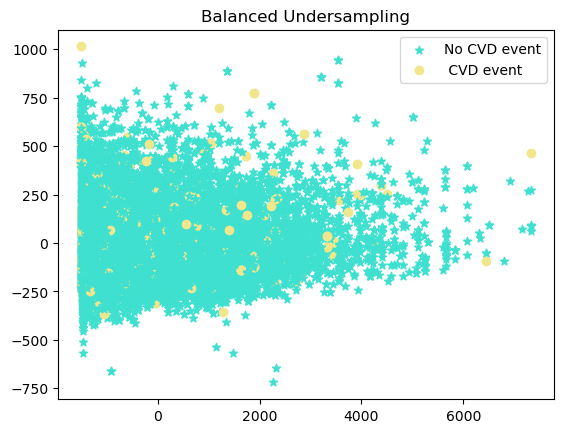

In [25]:
print('Balanced undersampling {}'.format(Counter(dff_Y_bal.CVD.values)))
pca = PCA(n_components=2).fit(dff_X_bal)
pca_2d = pca.transform(dff_X_bal)
# y_rs = y1['CVD']
pca_2d 
for i in range(0, pca_2d.shape[0]):
    if dff_Y_bal.CVD.values[i] == 1:
      c1 = pl.scatter(pca_2d[i,0],pca_2d[i,1],c='khaki', marker='o')
    elif dff_Y_bal.CVD.values[i] == 0:
      c2 = pl.scatter(pca_2d[i,0],pca_2d[i,1],c='turquoise', marker='*')  
pl.legend([c2, c1], ['No CVD event', ' CVD event'])
pl.title('Balanced Undersampling')
# pl.axis([-4, 5, -4, 4])  # x axis (-4,5), y axis (-4,4)
pl.show()

In [217]:
# Split the data into train and test sets (stratified by sex)
train_features_bal, test_features_bal, train_targets_bal, test_targets_bal = train_test_split(
    dff_X_bal, dff_Y_bal, test_size=0.2, stratify=dff_X_bal[['sex']], random_state=42)

#### Resample the data (Undersampling given the target class imbalance) **after** split

In [189]:
# Split the data into train and test sets (stratified by sex)
train_features, test_features, train_targets, test_targets = train_test_split(
    treated[predictor_cols], y1, test_size=0.2, stratify=treated[['sex']], random_state=42)


In [ ]:

X_train_bal, Y_train_bal = resample_dataset(train_features, train_targets)
sampler = CondensedNearestNeighbour() 
train_bal_CNN_X, train_bal_CNN_Y = sampler.fit_resample(train_features, train_targets)
print('NearestNeighbours Clearning Rule undersampling {}'.format(Counter(train_bal_CNN_Y)))

In [172]:
sampler = CondensedNearestNeighbour() 
data_bal_CNN_X, data_bal_CNN_Y = sampler.fit_resample(treated[predictor_cols], y1)
print('NearestNeighbours Clearning Rule undersampling {}'.format(Counter(data_bal_CNN_Y)))
# Split the data into train and test sets (stratified by sex)
train_features1, test_features1, train_targets1, test_targets1 = train_test_split(
    data_bal_CNN_X[predictor_cols], data_bal_CNN_Y, test_size=0.2, stratify=data_bal_CNN_X[['sex']], random_state=42)

NearestNeighbours Clearning Rule undersampling Counter({'CVD': 1})


In [173]:
print('NearestNeighbours Clearning Rule undersampling {}'.format(Counter(data_bal_CNN_Y.CVD)))

NearestNeighbours Clearning Rule undersampling Counter({0: 1866, 1: 443})


### Develop pipelines for adopted machine learning algorithms

In [198]:
XGB_pipeline = Pipeline(steps=[
    ("preprocessing", StandardScaler()),
    ("XGBoost", xgb.XGBClassifier())
])

RF_pipeline = Pipeline(steps=[
    ("preprocessing", StandardScaler()),
    ("RandomForest", RandomForestClassifier())
])

GB_pipeline = Pipeline(steps=[
    ("preprocessing", StandardScaler()),
    ("RandomForest", GradientBoostingClassifier())
])

LR_pipeline = Pipeline(steps=[
    ("preprocessing", StandardScaler()),
    ("Logistic_Regression", LogisticRegression(max_iter=1000))
])

# DNN_pipepline = Pipeline(steps=[
#     ("preprocessing", StandardScaler()),
#     ("DNN_Model", LogisticRegression(max_iter=1000))
# ])

In [176]:
train_targets1

,CVD
1926,1
400,0
212,0
986,0
247,0
...,...
1697,0
2285,1
1067,0
1334,0


In [218]:
XGB_pipeline.fit(train_features_bal, train_targets_bal)
RF_pipeline.fit(train_features_bal, train_targets_bal)
LR_pipeline.fit(train_features_bal, train_targets_bal)
GB_pipeline.fit(train_features_bal, train_targets_bal)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Pipeline(steps=[('preprocessing', StandardScaler()),
                ('RandomForest', GradientBoostingClassifier())])

In [219]:
Y_pred_proba_XGB = XGB_pipeline.predict_proba(test_features_bal)[:,1]
Y_pred_XGB = XGB_pipeline.predict(test_features_bal)


Y_pred_proba_RF = RF_pipeline.predict_proba(test_features_bal)[:,1]
Y_pred_RF = RF_pipeline.predict(test_features_bal)

Y_pred_proba_LR = LR_pipeline.predict_proba(test_features_bal)[:,1]
Y_pred_LR = LR_pipeline.predict(test_features_bal)

Y_pred_proba_GB = GB_pipeline.predict_proba(test_features_bal)[:,1]
Y_pred_GB = GB_pipeline.predict(test_features_bal)

In [220]:
print('XGB accuracy', roc_auc_score(test_targets_bal, Y_pred_proba_XGB))
print('RF accuracy', roc_auc_score(test_targets_bal, Y_pred_proba_RF))
print('LR accuracy', roc_auc_score(test_targets_bal, Y_pred_proba_LR))
print('GB accuracy', roc_auc_score(test_targets_bal, Y_pred_proba_GB))

XGB accuracy 0.7917686893419639
RF accuracy 0.8661354753381226
LR accuracy 0.6736648161167544
GB accuracy 0.7421432438766193


Text(0, 0.5, 'True Positive rate')

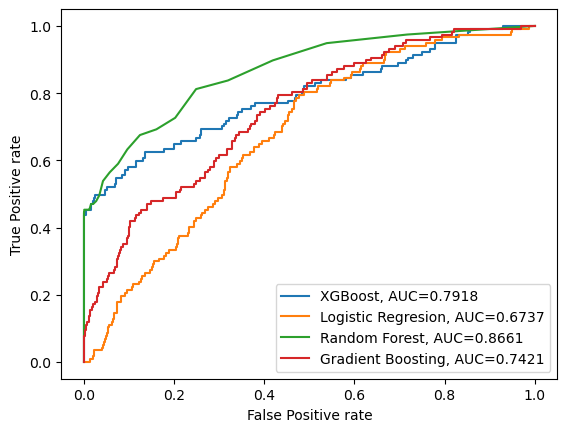

In [228]:
# RocCurveDisplay.from_predictions(test_targets, Y_pred_proba_XGB)
# RocCurveDisplay.from_predictions(test_targets, Y_pred_proba_RF)
# RocCurveDisplay.from_predictions(test_targets, Y_pred_proba_LR)
#set up plotting area

from sklearn import metrics
plt.figure(0).clf()

#fit logistic regression model and plot ROC curve
fpr, tpr, _ = metrics.roc_curve(test_targets_bal, Y_pred_proba_XGB)
auc = round(metrics.roc_auc_score(test_targets_bal, Y_pred_proba_XGB), 4)
plt.plot(fpr,tpr,label="XGBoost, AUC="+str(auc))

#fit gradient boosted model and plot ROC curve
fpr, tpr, _ = metrics.roc_curve(test_targets_bal, Y_pred_proba_LR)
auc = round(metrics.roc_auc_score(test_targets_bal, Y_pred_proba_LR), 4)
plt.plot(fpr,tpr,label="Logistic Regresion, AUC="+str(auc))

#fit gradient boosted model and plot ROC curve
fpr, tpr, _ = metrics.roc_curve(test_targets_bal, Y_pred_proba_RF)
auc = round(metrics.roc_auc_score(test_targets_bal, Y_pred_proba_RF), 4)
plt.plot(fpr,tpr,label="Random Forest, AUC="+str(auc))

#fit gradient boosted model and plot ROC curve
fpr, tpr, _ = metrics.roc_curve(test_targets_bal, Y_pred_proba_GB)
auc = round(metrics.roc_auc_score(test_targets_bal, Y_pred_proba_GB), 4)
plt.plot(fpr,tpr,label="Gradient Boosting, AUC="+str(auc))

#add legend
plt.legend()
plt.xlabel("False Positive rate")
plt.ylabel("True Positive rate")


Text(0, 0.5, 'True Positive rate')

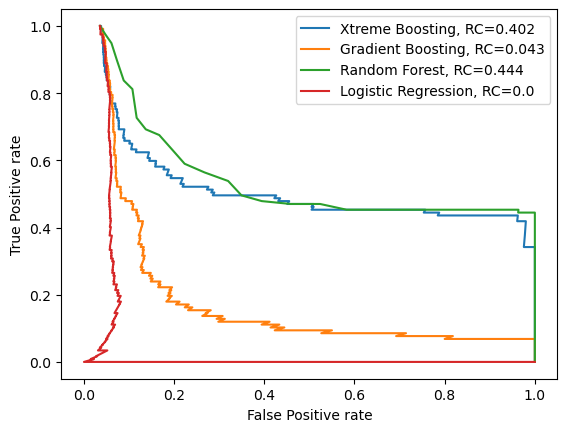

In [243]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay
plt.figure(0).clf()
prec, recall, _ = precision_recall_curve(test_targets_bal, Y_pred_proba_XGB, pos_label=XGB_pipeline.classes_[1])
RC = round(recall_score(test_targets_bal, Y_pred_XGB),3)
plt.plot(prec,recall,label="Xtreme Boosting, RC="+str(RC))
# prec, recall, _ = precision_recall_curve(test_targets_bal, Y_pred_proba_RF, pos_label=RF_pipeline.classes_[1])
# pr_display = PrecisionRecallDisplay(precision=prec, recall=recall).plot()
prec, recall, _ = precision_recall_curve(test_targets_bal, Y_pred_proba_GB, pos_label=GB_pipeline.classes_[1])
RC = round(recall_score(test_targets_bal, Y_pred_GB),3)
plt.plot(prec,recall,label="Gradient Boosting, RC="+str(RC))
prec, recall, _ = precision_recall_curve(test_targets_bal, Y_pred_proba_RF, pos_label=RF_pipeline.classes_[1])
# pr_display = PrecisionRecallDisplay(precision=prec, recall=recall).plot()
RC = round(recall_score(test_targets_bal, Y_pred_RF),3)
plt.plot(prec,recall,label="Random Forest, RC="+str(RC))
prec, recall, _ = precision_recall_curve(test_targets_bal, Y_pred_proba_LR, pos_label=LR_pipeline.classes_[1])
# pr_display = PrecisionRecallDisplay(precision=prec, recall=recall).plot()
RC = round(recall_score(test_targets_bal, Y_pred_LR),3)
plt.plot(prec,recall,label="Logistic Regression, RC="+str(RC))

#add legend
plt.legend()
plt.xlabel("False Positive rate")
plt.ylabel("True Positive rate")

In [248]:
# recall_score(test_targets_bal, Y_pred_RF)
balanced_accuracy_score(test_targets_bal, Y_pred_RF)

0.7222222222222222

In [ ]:
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, accuracy_score

# Split the dataset into train and test sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the pipelines for each model
pipelines = [
    ('XGBoost', Pipeline([
        ('scaler', StandardScaler()),
        ('clf', xgb.XGBClassifier())
    ])),
    ('Random Forest', Pipeline([
        ('scaler', StandardScaler()),
        ('clf', RandomForestClassifier())
    ])),
    ('Gradient Boosting', Pipeline([
        ('scaler', StandardScaler()),
        ('clf', GradientBoostingClassifier())
    ])),
    ('Logistic Regression', Pipeline([
        ('scaler', StandardScaler()),
        ('clf', LogisticRegression())
    ]))
]

# Define the parameter grids for each model
param_grids = [
    {
        'clf__n_estimators': [100, 200, 300],
        'clf__max_depth': [3, 5, 7]
    },
    {
        'clf__n_estimators': [100, 200, 300],
        'clf__max_depth': [3, 5, 7]
    },
    {
        'clf__n_estimators': [100, 200, 300],
        'clf__max_depth': [3, 5, 7]
    },
    {
        'clf__C': [0.1, 1.0, 10.0]
    }
]

# Perform GridSearchCV for each model
for (model_name, pipeline), param_grid in zip(pipelines, param_grids):
    print(f"GridSearchCV for {model_name}...")

    # Perform GridSearchCV
    grid_search = GridSearchCV(pipeline, param_grid, scoring='roc_auc', cv=3)
    grid_search.fit(X_train_bal, Y_train_bal)

    # Get the best model and its parameters
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_

    # Evaluate the best model on the test set
    y_pred_actual = best_model.predict(test_features)
    y_pred_proba = best_model.predict_proba(test_features)[:, 1]

    roc_auc = roc_auc_score(test_targets, y_pred_proba)
    accuracy = accuracy_score(test_targets, y_pred_actual)

    print(f"Best Parameters: {best_params}")
    print(f"ROC-AUC Score: {roc_auc:.4f}")
    print(f"Accuracy: {accuracy:.4f}")
    print("-----------------------------------\n")


In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

# y_pred = clf.predict(test_features)
cm_xgb = confusion_matrix(test_targets_bal, Y_pred_XGB)
cm_rf = confusion_matrix(test_targets_bal, Y_pred_RF)
cm_lr = confusion_matrix(test_targets_bal, Y_pred_LR)

ConfusionMatrixDisplay(cm_xgb).plot()
ConfusionMatrixDisplay(cm_rf).plot()
ConfusionMatrixDisplay(cm_lr).plot()

In [ ]:
CM = {'XGB': cm_xgb,
      'RF': cm_rf,
      'LR': cm_lr}
ConfusionMatrixDisplay(CM).plot(
    subplots=True,
    layout=[1, 3],
    # ylim=[0, 1],
    legend=False,
    figsize=[8, 6],
    colormap="Accent",
    title="Fairness across the Sex group",
)


In [280]:
from sklearn.utils import class_weight
classes_weights = class_weight.compute_sample_weight(
    class_weight='balanced',
    y=train_targets_bal
)
modelx = xgb.XGBClassifier()
modelx.fit(train_features_bal,train_targets_bal, sample_weight=classes_weights)
model = RandomForestClassifier()

In [281]:
from fairlearn.reductions import ExponentiatedGradient, DemographicParity
from sklearn.metrics import accuracy_score
from fairlearn.metrics import (
    MetricFrame,
    true_positive_rate,
    false_positive_rate,
    false_negative_rate,
    selection_rate,
    count,
    false_negative_rate_difference
)

from fairlearn.postprocessing import ThresholdOptimizer, plot_threshold_optimizer
from fairlearn.postprocessing._interpolated_thresholder import InterpolatedThresholder
from fairlearn.postprocessing._threshold_operation import ThresholdOperation
from fairlearn.reductions import ExponentiatedGradient, EqualizedOdds, TruePositiveRateParity

# Train a fairness-aware model using the ExponentiatedGradient algorithm with DemographicParity constraint
sensitive_feature = 'sex'  # Choose the sensitive feature used for fairness considerations
constraint = DemographicParity()

fair_model = ExponentiatedGradient(modelx, constraint)
fair_model.fit(train_features_bal, train_targets_bal, sensitive_features=train_features_bal.sex)

# Evaluate the fairness-aware model
fair_preds = fair_model.predict(test_features_bal)
print("Fairness-Aware Model:")
print(classification_report(test_targets_bal, fair_preds))
print("Gradient Boosting:")
print(classification_report(test_targets_bal, Y_pred_GB))

Fairness-Aware Model:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      3173
           1       0.98      0.43      0.60       117

    accuracy                           0.98      3290
   macro avg       0.98      0.71      0.79      3290
weighted avg       0.98      0.98      0.98      3290

Gradient Boosting:
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      3173
           1       1.00      0.04      0.08       117

    accuracy                           0.97      3290
   macro avg       0.98      0.52      0.53      3290
weighted avg       0.97      0.97      0.95      3290



In [283]:
display(Markdown("**XGBoost**:"))
yypred = modelx.predict(test_features_bal)
yypredprob = modelx.predict_proba(test_features_bal)[:,1]
print(recall_score(test_targets_bal, yypred))

**XGBoost**:

0.452991452991453


In [284]:
from fairlearn.metrics import demographic_parity_difference
print(demographic_parity_difference(test_targets_bal.CVD.values,
                                    fair_preds,
                                    sensitive_features=test_features_bal.sex.values))
from fairlearn.metrics import demographic_parity_ratio
print(demographic_parity_ratio(test_targets_bal.CVD.values,
                                    fair_preds,
                                    sensitive_features=test_features_bal.sex.values))

0.005173564753004005
0.7102803738317757


In [285]:
from fairlearn.metrics import equalized_odds_difference
print('Equalized Odd Difference:',equalized_odds_difference(test_targets_bal.CVD.values,
                                    fair_preds,
                                    sensitive_features=test_features_bal.sex.values))

from fairlearn.metrics import equalized_odds_ratio
print(equalized_odds_ratio(test_targets_bal.CVD.values,
                                    fair_preds,
                                    sensitive_features=test_features_bal.sex.values))
from fairlearn.metrics import make_derived_metric, MetricFrame
from sklearn.metrics import recall_score
recall_difference = make_derived_metric(metric=recall_score,
                                       transform='difference')
display(Markdown('Recall difference'))
recall_difference(test_targets_bal.CVD.values,
                                    fair_preds,
                                    sensitive_features=test_features_bal.sex.values)
MetricFrame(metrics=recall_score,
            y_true=test_targets_bal.CVD.values,
            y_pred=fair_preds,
            sensitive_features=test_features_bal.sex.values).difference()

Equalized Odd Difference: 0.017971758664955095
0.0


Recall difference

0.017971758664955095

In [288]:
import functools
from sklearn.metrics import fbeta_score
fbeta_06 = functools.partial(fbeta_score, beta=0.6)
metric_beta = MetricFrame(metrics=fbeta_06,
                          y_true=test_targets_bal.CVD.values,
                          y_pred=fair_preds,
                          sensitive_features=test_features_bal.sex.values)
print(metric_beta.difference())
print(metric_beta.by_group)
print(metric_beta.ratio())
metric_beta.overall

0.008035155401694083
sensitive_feature_0
0.0    0.733154
1.0    0.725118
Name: metric, dtype: float64
0.9890402843601893


Supplied 'func' had no __name__ attribute


0.7302405498281787

In [289]:
s_w = test_features_bal.smoking_status_c_qc
s_p = { 'sample_weight':s_w }
weighted = MetricFrame(metrics=recall_score,
                       y_true=test_targets_bal.CVD,
                       y_pred=fair_preds,
                       sensitive_features=pd.Series(test_features_bal.sex, name='SEX'),
                       sample_params=s_p)
print(weighted.overall)
weighted.by_group

0.5238095238095238


SEX
0.0    0.666667
1.0    0.484848
Name: recall_score, dtype: float64

In [290]:
table_fair = pd.DataFrame(dict(y_true=test_targets_bal.CVD, y_pred=Y_pred_RF, sex=test_features_bal['sex'].astype(str)))

def compute_mf(df:pd.DataFrame) -> pd.DataFrame:
    mf1 = MetricFrame(metrics={"false negative rate":false_negative_rate, "selection rate": selection_rate},
                  y_true=df.y_true,
                  y_pred=df.y_pred,
                  sensitive_features=test_features_bal['sex'])
    return mf1.by_group.reset_index()

compute_mf(table_fair)

,sex,false negative rate,selection rate
0,0.0,0.552632,0.018973
1,1.0,0.560976,0.012016


In [267]:
s_w_1 = test_features_bal.smoking_status_c_qc
s_w_2 = test_features_bal.alcohol_use_status_c_qc
tdd = pd.DataFrame(dict(y_true=test_targets_bal.CVD, y_pred=fair_preds, smoking=s_w_1.astype(str), alcohol=s_w_2.astype(str)))
metrics = {
   'recall' : recall_score,
   'recall_weighted' : recall_score,
   'recall_weight_2' : recall_score
}
s_p = {
    'recall_weighted' : { 'sample_weight':s_w_1 },
    'recall_weight_2' : { 'sample_weight':s_w_2 }
}
def compute_mf2(df:pd.DataFrame) -> pd.DataFrame:
    weighted = MetricFrame(metrics=metrics,
                        y_true=df.y_true,
                        y_pred=df.y_pred,
                        sensitive_features=pd.Series(test_features_bal.sex, name='Sex'),
                        sample_params=s_p,
                        control_features=s_w_1)
    return weighted.by_group.reset_index()
compute_mf2(tdd)

Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.


,smoking_status_c_qc,Sex,recall,recall_weighted,recall_weight_2
0,0.0,0.0,0.436620,0.000000,0.396825
1,0.0,1.0,0.368421,0.000000,0.400000
2,1.0,0.0,0.000000,0.000000,0.000000
3,1.0,1.0,0.545455,0.545455,0.611111
4,2.0,0.0,0.750000,0.750000,0.900000
5,2.0,1.0,0.454545,0.454545,0.590909


array([[<Axes: title={'center': 'Accuracy'}, xlabel='sex'>,
        <Axes: title={'center': 'Precision score'}, xlabel='sex'>],
       [<Axes: title={'center': 'False negative rate'}, xlabel='sex'>,
        <Axes: title={'center': 'Selection rate'}, xlabel='sex'>]],
      dtype=object)

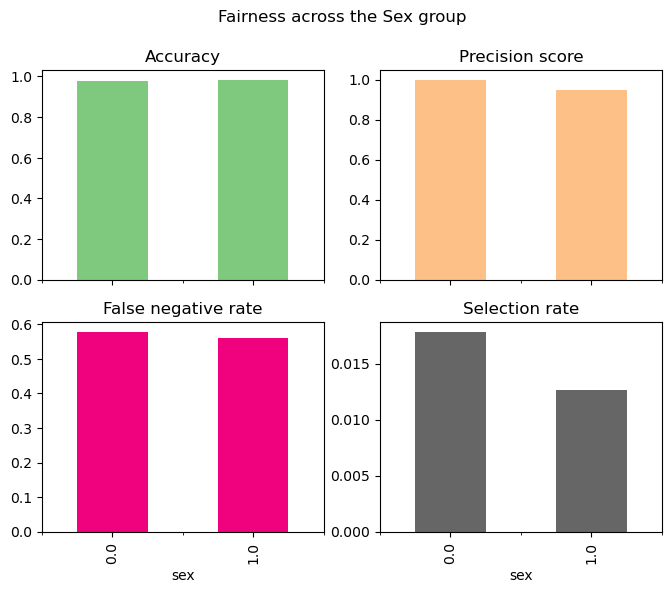

In [291]:
from sklearn.metrics import precision_score
metrics = {
    "Accuracy": accuracy_score,
    "Precision score": precision_score,
    # "false positive rate": false_positive_rate,
     "False negative rate": false_negative_rate,
    "Selection rate": selection_rate,
    # "count": count,
}
metric_frame = MetricFrame(
    metrics=metrics, y_true=test_targets_bal.CVD, y_pred=fair_preds, sensitive_features=test_features_bal.sex
)
metric_frame.by_group.plot.bar(
    subplots=True,
    layout=[2, 2],
    # ylim=[0, 1],
    legend=False,
    figsize=[8, 6],
    colormap="Accent",
    title="Fairness across the Sex group",
)

In [292]:
from sklearn.metrics import confusion_matrix

# Evaluate the fairness-aware model on the test set
fair_preds = fair_model.predict(test_features_bal)
# print("Fairness-Aware Model:")
# print(classification_report(test_targets['stroke'], fair_preds))

# Calculate the confusion matrix
confusion = confusion_matrix(test_targets_bal.CVD, fair_preds)
# print("Confusion Matrix:")
display(Markdown('__Confusion Matrix:__'))
# display(Markdown(confusion))
print(confusion)

# Identify instances where the model makes mistakes
misclassified_indices = np.where(test_targets_bal.CVD != fair_preds)[0]

# Print example misclassified instances
for idx in misclassified_indices[:5]:
    print("Instance:", idx)
    # print("Features:", test_features_bal.iloc[idx])
    print("True Label:", test_targets_bal['CVD'].iloc[idx]) # ?????? 
    print("Predicted Label:", fair_preds[idx])
    print("-----+++++--------")

__Confusion Matrix:__

[[3172    1]
 [  67   50]]
Instance: 40
True Label: 1
Predicted Label: 0
-----+++++--------
Instance: 45
True Label: 1
Predicted Label: 0
-----+++++--------
Instance: 77
True Label: 1
Predicted Label: 0
-----+++++--------
Instance: 130
True Label: 1
Predicted Label: 0
-----+++++--------
Instance: 179
True Label: 1
Predicted Label: 0
-----+++++--------


In [294]:
from sklearn.preprocessing import StandardScaler
# Get feedback from the user for a specific instance
# from sklearn.preprocessing import scale

scaler = StandardScaler().fit(train_features_bal) 
user_feedback_instance = 3  # Choose the index of the instance for user feedback

# Get the user's feedback (e.g., correct label)
user_correct_label = 1  # Choose the correct label provided by the user

# Update the model using the user's feedback
updated_train_features = train_features_bal.copy()
updated_train_features.iloc[user_feedback_instance] = test_features_bal.iloc[user_feedback_instance]  # Replace the instance in the training set with the user-provided instance
updated_train_targets = train_targets_bal.copy()
updated_train_targets['CVD'].iloc[user_feedback_instance] = user_correct_label  # Replace the label in the training set with the user-provided correct label

# Retrain the model with the updated training set
# fair_model1 = ExponentiatedGradient(model, constraint)
# Define the fairness-aware model using the ExponentiatedGradient algorithm with Demographic Parity fairness constraint
fair_model1 = ExponentiatedGradient(
    modelx,
    constraints=DemographicParity(),
    # epsilon=0.05  # Fairness tolerance parameter
)
fair_model1.fit(
    scaler.transform(updated_train_features), updated_train_targets['CVD'], 
    sensitive_features=updated_train_features[sensitive_feature])

# Evaluate the updated model
updated_fair_preds = fair_model1.predict(test_features_bal)
display(Markdown("Fairness-Aware Model:"))
print(roc_auc_score(test_targets_bal['CVD'], fair_preds))
print("Updated Fairness-Aware Model:")
print(roc_auc_score(test_targets_bal['CVD'], updated_fair_preds))
# print("Updated Fairness-Aware Model:")
# print(roc_auc_score(test_targets['cardio'], xgb_preds))


Fairness-Aware Model:

0.7135176340975269
Updated Fairness-Aware Model:
0.5


In [298]:
# Measure overall accuracy
overall_accuracy = accuracy_score(test_targets_bal.CVD, fair_preds)
print(" Fair Overall Accuracy:", overall_accuracy)
overall_accuracy = accuracy_score(test_targets_bal.CVD, yypred)
print("Overall Accuracy:", overall_accuracy)

 Fair Overall Accuracy: 0.9793313069908814
Overall Accuracy: 0.9717325227963526


In [299]:
model.fit(train_features_bal, train_targets_bal['CVD'])
model.feature_importances_
initial_preds = model.predict(test_features_bal)

# Perform active learning with user feedback
num_instances_to_query = 5  # Number of instances to query for user feedback

# Select the most uncertain instances from the test set
uncertainty_scores = model.predict_proba(test_features_bal)[:, 1]  # Get the probability of the positive class
most_uncertain_indices = np.argsort(np.abs(uncertainty_scores - 0.5))[:num_instances_to_query]
selected_instances = test_features_bal.iloc[most_uncertain_indices]

# Get user feedback for the selected instances
user_feedback_labels = [0, 1, 0, 1, 0]  # Replace with the user-provided feedback labels for the selected instances

# Incorporate the user feedback into the training set
updated_train_features = pd.concat([train_features_bal, selected_instances])
updated_train_target = pd.concat([train_targets_bal['CVD'], pd.Series(user_feedback_labels)])

# Retrain the XGBoost model with the updated training set
updated_xgb_model = modelx
updated_xgb_model.fit(updated_train_features, updated_train_target)

# Evaluate the updated model on the test set
updated_preds = updated_xgb_model.predict(test_features_bal)
print("XGBoost Model:")
print(accuracy_score(test_targets_bal, yypred))
print("Fair XGBoost Model:")
print(accuracy_score(test_targets_bal, fair_preds))
print("Updated XGBoost Model:")
print(accuracy_score(test_targets_bal, updated_preds))

XGBoost Model:
0.9717325227963526
Fair XGBoost Model:
0.9793313069908814
Updated XGBoost Model:
0.9778115501519757


In [300]:
# You can also evaluate multiple metrics by providing a dictionary

metrics_dict = {
    "selection_rate": selection_rate,
    "false_negative_rate": false_negative_rate,
    "balanced_accuracy": balanced_accuracy_score,
}

metricframe_unmitigated = MetricFrame(metrics=metrics_dict,
                  y_true=test_targets_bal,
                  y_pred=yypred,
                  sensitive_features=test_features_bal.sex)

# The disaggregated metrics are then stored in a pandas DataFrame:

metricframe_unmitigated.by_group.reset_index()

,sex,selection_rate,false_negative_rate,balanced_accuracy
0,0.0,0.031250,0.539474,0.724144
1,1.0,0.017356,0.560976,0.716767


In [301]:
pd.DataFrame({'difference': metricframe_unmitigated.difference(),
              'ratio': metricframe_unmitigated.ratio(),
              'group_min': metricframe_unmitigated.group_min(),
              'group_max': metricframe_unmitigated.group_max()}).T

,selection_rate,false_negative_rate,balanced_accuracy
difference,0.013894,0.021502,0.007377
ratio,0.555407,0.96167,0.989812
group_min,0.017356,0.539474,0.716767
group_max,0.03125,0.560976,0.724144


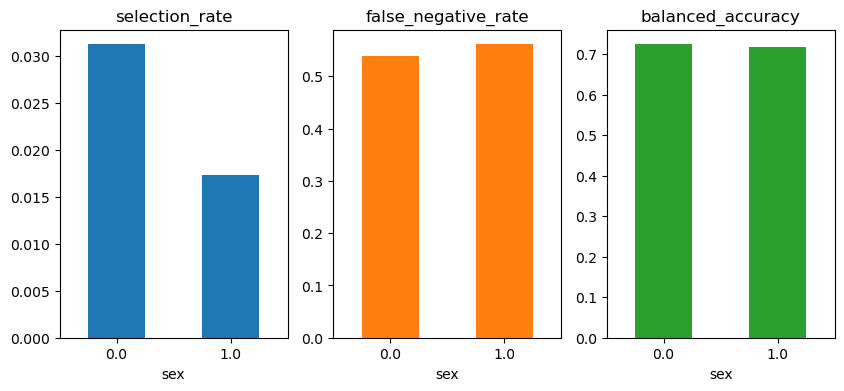

In [302]:
metricframe_unmitigated.by_group.plot.bar(subplots=True, layout= [1,3], figsize=(10, 4),
                      legend=False, rot=0, position=0.5);

For a large difference in false negative rates between the groups, we need to implement **algorithmic mitigation strategies** of this fairness issue (and similar ones).

*Note that while we currently focus on the training stage of the AI lifecycle mitigation should not be limited to this stage. In fact, we have already discussed mitigation strategies that are applicable at the task definition stage (e.g., checking for construct validity) and data collection stage (e.g., collecting more data).*

Within the model training stage, mitigation may occur at different steps relative to model training:

* **Preprocessing**: A mitigation algorithm is applied to transform the input data to the training algorithm; for example, some strategies seek to remove and dependence between the input features and sensitive features.

* **At training time**: $\text{The model is trained by an (optimization) algorithm that seeks to satisfy fairness constraints.}$

* **Postprocessing**: The output of a trained model is transformed to mitigate fairness issues; for example, the predicted probability of CVD event is thresholded according to a group-specific threshold.

We will now dive into two algorithms: a postprocessing approach and a reductions approach (which is a training-time algorithm). Both of them are in fact **meta-algorithms** in the sense that they act as wrappers around *any* standard (fairness-unaware) machine learning algorithms. This makes them quite versatile in practice.

The Threshold optimizer is a **Postprocessing** technique; a class of unfairness-mitigation algorithms that take an already trained model and a dataset as an input and seek to fit a transformation function to model's outputs to satisfy some (group) fairness constraint(s). They might be the only feasible unfairness mitigation approach when developers cannot influence training of the model, due to practical reasons or due to security or privacy.

The $\text{ThresholdOptimizer}$ takes:

*   An existing `estimator` that we wish to threshold. 
*   The fairness `constraints` we want to satisfy.
*   The `objective` metric we want to maximize.

In [329]:
postprocess_est = ThresholdOptimizer(
    estimator=XGB_pipeline,
    constraints="false_negative_rate_parity",
    objective="balanced_accuracy_score",
    prefit=True,
    predict_method='predict_proba'
)

In [330]:
postprocess_est.fit(train_features_bal, train_targets_bal, sensitive_features=train_features_bal.sex)

ThresholdOptimizer(constraints='false_negative_rate_parity',
                   estimator=Pipeline(steps=[('preprocessing',
                                              StandardScaler()),
                                             ('XGBoost',
                                              XGBClassifier(base_score=0.5,
                                                            booster='gbtree',
                                                            callbacks=None,
                                                            colsample_bylevel=1,
                                                            colsample_bynode=1,
                                                            colsample_bytree=1,
                                                            early_stopping_rounds=None,
                                                            enable_categorical=False,
                                                            eval_metric=None,
                                                            feature_types=None,
                                                            gamma=0, gpu...
                                                            interaction_constraints='',
                                                            learning_rate=0.300000012,
                                                            max_bin=256,
                                                            max_cat_threshold=64,
                                                            max_cat_to_onehot=4,
                                                            max_delta_step=0,
                                                            max_depth=6,
                                                            max_leaves=0,
                                                            min_child_weight=1,
                                                            missing=nan,
                                                            monotone_constraints='()',
                                                            n_estimators=100,
                                                            n_jobs=0,
                                                            num_parallel_tree=1,
                                                            predictor='auto',
                                                            random_state=0, ...))]),
                   objective='balanced_accuracy_score',
                   predict_method='predict_proba', prefit=True)

In [331]:
# Record and evaluate the output of the trained ThresholdOptimizer on test data

Y_pred_postprocess = postprocess_est.predict(test_features_bal, sensitive_features=test_features_bal.sex)
metricframe_postprocess = MetricFrame(
    metrics=metrics_dict,
    y_true=test_targets_bal,
    y_pred=Y_pred_postprocess,
    sensitive_features=test_features_bal.sex
)

In [332]:
pd.concat([metricframe_unmitigated.by_group,
           metricframe_postprocess.by_group],
           keys=['Unmitigated', 'ThresholdOptimizer'],
           axis=1)

Unmitigated                                       ThresholdOptimizer  \
    selection_rate false_negative_rate balanced_accuracy     selection_rate   
sex                                                                           
0.0       0.031250            0.539474          0.724144           0.044085   
1.0       0.017356            0.560976          0.716767           0.018692   

                                           
    false_negative_rate balanced_accuracy  
sex                                        
0.0            0.513158          0.731183  
1.0            0.536585          0.728619

In [333]:
pd.concat([metricframe_unmitigated.difference(),
           metricframe_postprocess.difference()],
          keys=['Unmitigated: difference', 'ThresholdOptimizer: difference'],
          axis=1).T

,selection_rate,false_negative_rate,balanced_accuracy
Unmitigated: difference,0.013894,0.021502,0.007377
ThresholdOptimizer: difference,0.025393,0.023427,0.002565


array([[<Axes: title={'center': 'selection_rate'}, xlabel='sex'>,
        <Axes: title={'center': 'false_negative_rate'}, xlabel='sex'>,
        <Axes: title={'center': 'balanced_accuracy'}, xlabel='sex'>]],
      dtype=object)

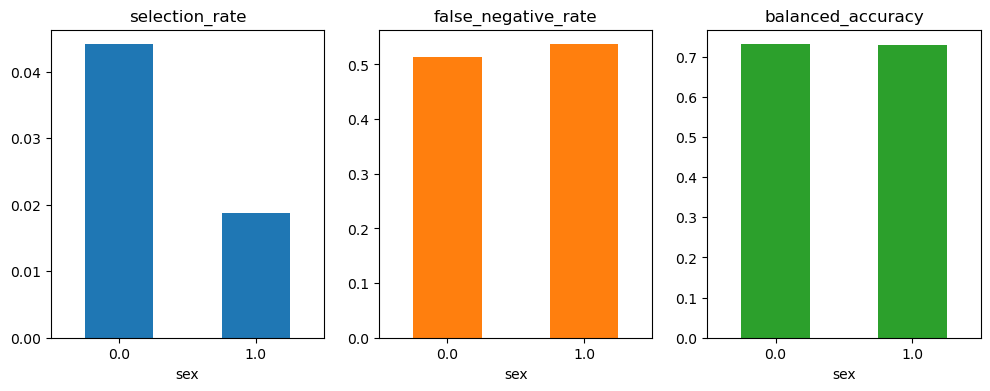

In [334]:
metricframe_postprocess.by_group.plot.bar(subplots=True, layout=[1,3], figsize=(12, 4), legend=False, rot=0, position=0.5)

## Fairness mitigation

### Reductions approach using $\text{ExponentiatedGradient}$

In [311]:
from sklearn.linear_model import LogisticRegression
random_seed = 42;
expgrad_est = ExponentiatedGradient(
    estimator=LogisticRegression(max_iter=5000, random_state=random_seed),
    constraints=TruePositiveRateParity(difference_bound=0.007)
)

In [312]:
# Fit the exponentiated gradient model
expgrad_est.fit(train_features_bal, train_targets_bal, sensitive_features=train_features_bal.sex)

ExponentiatedGradient(constraints=<fairlearn.reductions._moments.utility_parity.TruePositiveRateParity object at 0x7fdaf1783f40>,
                      estimator=LogisticRegression(max_iter=5000,
                                                   random_state=42),
                      nu=0.0008189336192888777)

In [313]:
# Record and evaluate predictions on test data

Y_pred_reductions = expgrad_est.predict(test_features_bal, random_state=random_seed)
metricframe_reductions = MetricFrame(
    metrics=metrics_dict,
    y_true=test_targets_bal,
    y_pred=Y_pred_reductions,
    sensitive_features=test_features_bal.sex
)
metricframe_reductions.by_group.reset_index()

,sex,selection_rate,false_negative_rate,balanced_accuracy
0,0.0,0.0,1.0,0.5
1,1.0,0.0,1.0,0.5


In [314]:
# Evaluate the difference between the largest and smallest value of each metric
metricframe_reductions.difference()

selection_rate         0.0
false_negative_rate    0.0
balanced_accuracy      0.0
dtype: float64

#### Individual predictors

During the training process, the $\text{ExponentiatedGradient}$ algorithm iteratively trains multiple inner models on a reweighted training dataset. The algorithm stores each of these predictors and then randomizes among them at deployment time.

In many applications, the randomization is undesirable, and also using multiple inner models can pose issues for interpretability. However, the inner models that $\text{ExponentiatedGradient}$ relies on span a variety of fairness-accuracy trade-offs, and they could be considered for stand-alone deployment: addressing the randomization and interpretability issues, while possibly offering additional flexibility thanks to a variety of trade-offs. 

In this section explore the performance of the individual predictors learned by the $\text{ExponentiatedGradient}$ algorithm. First, note that since the base estimator was $\text{LogisticRegression}$ all these predictors are different logistic regression models:

In [316]:
predictors = expgrad_est.predictors_
predictors

0    LogisticRegression(max_iter=5000, random_state...
dtype: object

In [317]:
# Collect predictions by all predictors and calculate balanced error
# as well as the false negative difference for all of them

sweep_preds = [clf.predict(test_features_bal) for clf in predictors]
balanced_error_sweep = [1-balanced_accuracy_score(test_targets_bal, Y_sweep) for Y_sweep in sweep_preds]
fnr_diff_sweep = [false_negative_rate_difference(test_targets_bal, Y_sweep, sensitive_features=test_features_bal.sex) for Y_sweep in sweep_preds]

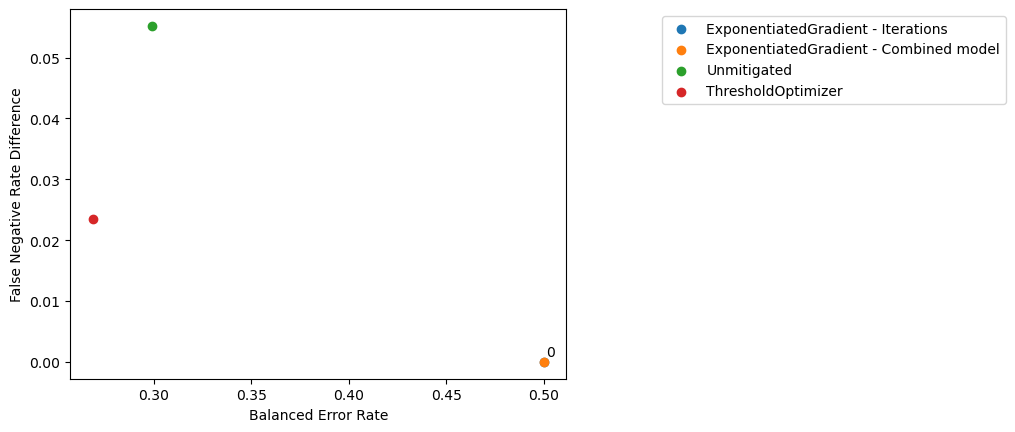

In [335]:
# Show the balanced error / fnr difference values of all predictors on a raster plot  

plt.scatter(balanced_error_sweep, fnr_diff_sweep, label="ExponentiatedGradient - Iterations")
for i in range(len(predictors)):
  plt.annotate(str(i), xy=(balanced_error_sweep[i]+0.001, fnr_diff_sweep[i]+0.001))

# Also include in the plot the combined ExponentiatedGradient model
# as well as the three previously fitted models

plt.scatter(1-balanced_accuracy_score(test_targets_bal, Y_pred_reductions),
            false_negative_rate_difference(test_targets_bal, Y_pred_reductions, sensitive_features=test_features_bal.sex),
            label="ExponentiatedGradient - Combined model")
plt.scatter(1-balanced_accuracy_score(test_targets_bal, Y_pred_XGB),
            false_negative_rate_difference(test_targets_bal, Y_pred_XGB, sensitive_features=test_features_bal.sex),
            label="Unmitigated")
plt.scatter(1-balanced_accuracy_score(test_targets_bal, Y_pred_postprocess),
            false_negative_rate_difference(test_targets_bal, Y_pred_postprocess, sensitive_features=test_features_bal.sex),
            label="ThresholdOptimizer")

plt.xlabel("Balanced Error Rate")
plt.ylabel("False Negative Rate Difference")
plt.legend(bbox_to_anchor=(1.9,1))
plt.show()

## Comparing performance of different techniques

Now we have covered two different class of techniques for mitigating the fairness-related harms we found in our fairness-unaware model. In this section, we will compare the performance of the models we trained above across our key metrics.

In [ ]:
# sexxx = ["Women" if dff[predictor_cols].iloc[i,2] == 0 else "Men" for i in range(dff.shape[0])]
# sexx = pd.DataFrame(sexxx)

In [342]:
def plot_technique_comparison(mf_dict, metric):
  """
  Plots a specified metric for a given dictionary of MetricFrames.
  """
  mf_dict = {k:v.by_group[metric] for (k,v) in mf_dict.items()}
  comparison_df = pd.DataFrame.from_dict(mf_dict)
  comparison_df.plot.bar(figsize=(12, 6), legend=False)
  plt.title(metric)
  plt.xticks(rotation=0, ha='center');
  plt.legend(bbox_to_anchor=(1.01,1), loc='upper left')
  
test_dict = {
"Reductions": metricframe_reductions,
"Unmitigated": metricframe_unmitigated,
"Postprocessing": metricframe_postprocess
}

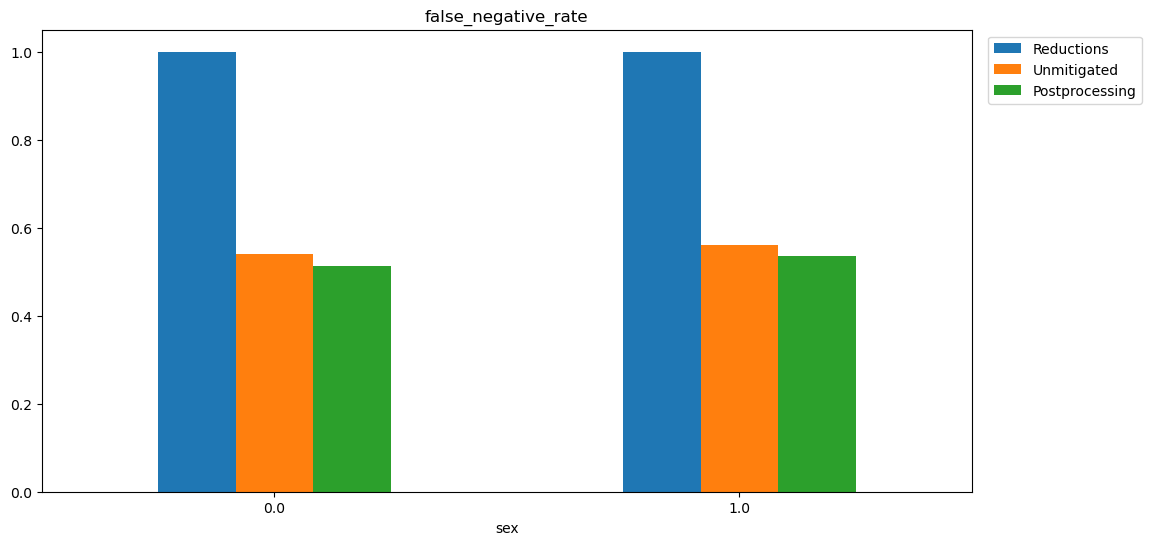

In [343]:
plot_technique_comparison(test_dict, "false_negative_rate")

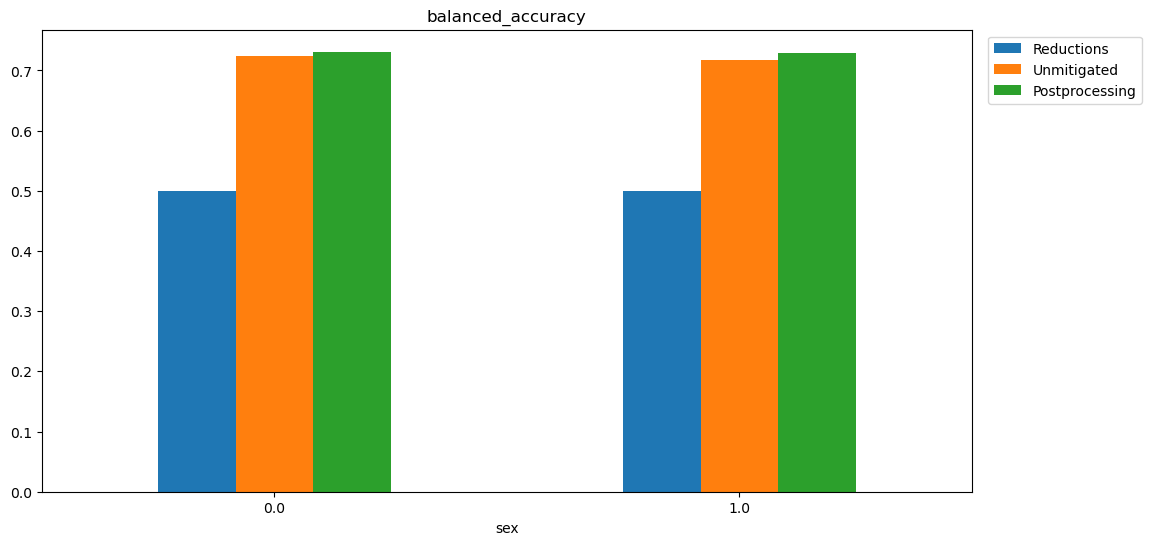

In [344]:
plot_technique_comparison(test_dict, "balanced_accuracy")

In [345]:
overall_df = pd.DataFrame.from_dict({
    "Unmitigated": metricframe_unmitigated.overall,
    "Postprocessing": metricframe_postprocess.overall,
    "Reductions": metricframe_reductions.overall
})
overall_df.T

,selection_rate,false_negative_rate,balanced_accuracy
Unmitigated,0.024924,0.547009,0.721926
Postprocessing,0.032523,0.521368,0.731280
Reductions,0.000000,1.000000,0.500000


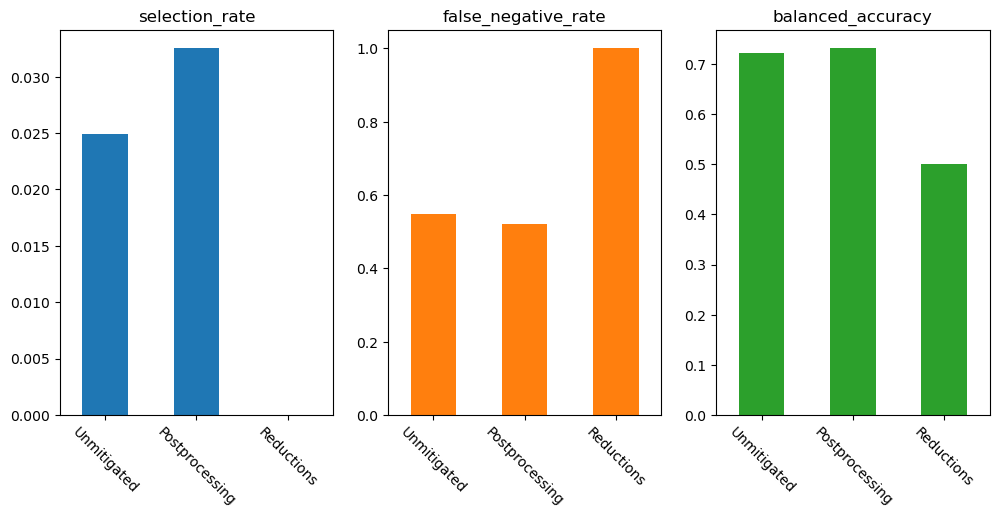

In [346]:
overall_df.transpose().plot.bar(subplots=True, layout= [1,3], figsize=(12, 5), legend=False, rot=-45, position=0.5);